In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import random
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, FeaturesData
import plotly.express as px
from scipy.spatial import cKDTree

import warnings
import lightgbm as lgb
from sklearn.model_selection import KFold

In [2]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
toilets_df = pd.read_csv("toilets.csv")
waste_management_df = pd.read_csv("waste_management.csv")
water_sources_df = pd.read_csv("water_sources.csv")

train_df = train_df.rename(columns={'Transformed_Latitude': 'Lat', 'Transformed_Longitude': 'Lon', })
test_df = test_df.rename(columns={'Transformed_Latitude': 'Lat', 'Transformed_Longitude': 'Lon', })
toilets_df = toilets_df.rename(columns={'Transformed_Latitude': 'Lat', 'Transformed_Longitude': 'Lon', })
waste_management_df = waste_management_df.rename(columns={'Transformed_Latitude': 'Lat', 'Transformed_Longitude': 'Lon', })
water_sources_df = water_sources_df.rename(columns={'Transformed_Latitude': 'Lat', 'Transformed_Longitude': 'Lon', })

In [3]:
train_df

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Lat,Lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
...,...,...,...,...,...,...,...,...,...
23843,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f_12_202...,0.0,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,12,2022,-8.63058,68.23478
23844,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f_12_202...,0.0,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,12,2022,-8.63058,68.23478
23845,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f_12_202...,0.0,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,12,2022,-8.63058,68.23478
23846,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f_12_202...,0.0,ID_776a9566-8bcb-4936-83a9-e8ef57834a9f,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,12,2022,-8.63058,68.23478


In [4]:
cat_cols = train_df.drop(columns=['ID', 'Category_Health_Facility_UUID']).select_dtypes(include=['category', 'object']).columns.tolist()
cat_cols

['Location', 'Disease']

In [5]:
train_df = train_df.dropna(subset=['Total'])
train_df['Total'].isna().sum()

0

In [6]:
# no_total = train_df.drop(columns=['Total'])
train_df = train_df.sort_values(by='Total', ascending=False)

In [7]:
# train_df = train_df.drop_duplicates()
train_df[train_df.drop(columns=['Total']).duplicated(keep=False)]

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Lat,Lon
919,ID_90ae3848-6fe9-4326-95ee-d7b8679e7494_12_201...,489.0,ID_90ae3848-6fe9-4326-95ee-d7b8679e7494,b7f0a600-e19e-4c65-acb3-e28584dae35b,Malaria,12,2019,-8.62893,68.23959
9847,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_1_2019...,481.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,1,2019,-8.62369,68.24270
9891,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_5_2019...,472.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,5,2019,-8.62369,68.24270
9858,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_2_2019...,471.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,2,2019,-8.62369,68.24270
9859,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_2_2019...,470.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,2,2019,-8.62369,68.24270
...,...,...,...,...,...,...,...,...,...
9171,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_11_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,11,2021,-8.68267,68.22165
9169,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_11_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,11,2021,-8.68267,68.22165
9167,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_11_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,11,2021,-8.68267,68.22165
9166,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_11_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,11,2021,-8.68267,68.22165


In [8]:
dup_subset = train_df.drop(columns=['Total']).columns.tolist()
filtered = train_df.drop_duplicates(subset=dup_subset, keep='first')
filtered

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Lat,Lon
919,ID_90ae3848-6fe9-4326-95ee-d7b8679e7494_12_201...,489.0,ID_90ae3848-6fe9-4326-95ee-d7b8679e7494,b7f0a600-e19e-4c65-acb3-e28584dae35b,Malaria,12,2019,-8.62893,68.23959
9847,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_1_2019...,481.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,1,2019,-8.62369,68.24270
9891,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_5_2019...,472.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,5,2019,-8.62369,68.24270
9858,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_2_2019...,471.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,2,2019,-8.62369,68.24270
15614,ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2_12_201...,464.0,ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2,b7f0a600-e19e-4c65-acb3-e28584dae35b,Malaria,12,2019,-8.57486,68.32839
...,...,...,...,...,...,...,...,...,...
9175,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_12_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2021,-8.68267,68.22165
9174,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_12_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2021,-8.68267,68.22165
9168,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_11_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Schistosomiasis,11,2021,-8.68267,68.22165
9167,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10_11_202...,0.0,ID_777b4bae-d725-4a1a-9f4a-31b42ebc3e10,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,11,2021,-8.68267,68.22165


In [9]:
filtered[filtered.duplicated]

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Lat,Lon


In [10]:
train_df = filtered.copy().reset_index(drop=True)

In [11]:
# train_df['date'] = pd.to_datetime(train_df[['Year', 'Month']].assign(day=1))
# train_df['loc_dis'] = train_df['Location'].astype(str) + '_' + train_df['Disease'].astype(str)
# train_df.sort_values(by=['loc_dis', 'date']).to_csv('train_sort_by_date.csv')

In [12]:
train_df['Total'].max(), train_df['Total'].mean(), train_df['Total'].min()

(489.0, 14.144988847011769, 0.0)

In [13]:
train_df['log_Total'] = np.log(train_df['Total'] + 1)

In [14]:
train_df['log_Total'].max(), train_df['log_Total'].mean(), train_df['log_Total'].min()

(6.194405391104672, 1.2824013759035355, 0.0)

# Grouping Locations

In [15]:
copy_df = train_df.copy()
copy_df['Loc_Dis'] = copy_df['Location'] + '_' + copy_df['Disease']
high_df = copy_df[copy_df['Total'] > 200]
high_df

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Lat,Lon,log_Total,Loc_Dis
0,ID_90ae3848-6fe9-4326-95ee-d7b8679e7494_12_201...,489.0,ID_90ae3848-6fe9-4326-95ee-d7b8679e7494,b7f0a600-e19e-4c65-acb3-e28584dae35b,Malaria,12,2019,-8.62893,68.23959,6.194405,ID_90ae3848-6fe9-4326-95ee-d7b8679e7494_Malaria
1,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_1_2019...,481.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,1,2019,-8.62369,68.24270,6.177944,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_Diarrhea
2,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_5_2019...,472.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,5,2019,-8.62369,68.24270,6.159095,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_Diarrhea
3,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_2_2019...,471.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,2,2019,-8.62369,68.24270,6.156979,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_Diarrhea
4,ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2_12_201...,464.0,ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2,b7f0a600-e19e-4c65-acb3-e28584dae35b,Malaria,12,2019,-8.57486,68.32839,6.142037,ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2_Malaria
...,...,...,...,...,...,...,...,...,...,...,...
97,ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0_8_2021...,205.0,ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,8,2021,-8.62255,68.22360,5.327876,ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0_Diarrhea
98,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_12_202...,204.0,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,12,2021,-8.62369,68.24270,5.323010,ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_Diarrhea
99,ID_8efc0ee1-e183-4518-afc4-83b63b79b1f8_1_2020...,203.0,ID_8efc0ee1-e183-4518-afc4-83b63b79b1f8,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,1,2020,-8.71376,68.16972,5.318120,ID_8efc0ee1-e183-4518-afc4-83b63b79b1f8_Malaria
100,ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0_3_2020...,202.0,ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0,b7f0a600-e19e-4c65-acb3-e28584dae35b,Diarrhea,3,2020,-8.62255,68.22360,5.313206,ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0_Diarrhea


In [16]:
high_df['Location'].value_counts()

Location
ID_361566e9-3fa1-4c0e-9778-84d5dc605feb    29
ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0    24
ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2    18
ID_ddf39ebf-663b-4f32-92b1-a700598dd4b9     9
ID_02f25962-4419-4e72-9402-3f6c513ec454     9
ID_8b36c0ac-b46c-4c9a-af37-d6717faa340e     5
ID_90ae3848-6fe9-4326-95ee-d7b8679e7494     2
ID_ef027061-3d99-4215-8487-374b4ab4699a     2
ID_8efc0ee1-e183-4518-afc4-83b63b79b1f8     2
ID_69a65631-3c68-4800-9b1a-32996da92c7a     1
ID_6f399bd7-f181-432a-bddc-9fff8dca7f81     1
Name: count, dtype: int64

In [17]:
high_df['Loc_Dis'].value_counts()

Loc_Dis
ID_361566e9-3fa1-4c0e-9778-84d5dc605feb_Diarrhea            29
ID_ecc21577-6c70-4ba3-a2a2-1d9c0e0477f0_Diarrhea            24
ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2_Malaria             10
ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2_Diarrhea             7
ID_ddf39ebf-663b-4f32-92b1-a700598dd4b9_Malaria              4
ID_ddf39ebf-663b-4f32-92b1-a700598dd4b9_Typhoid              4
ID_8b36c0ac-b46c-4c9a-af37-d6717faa340e_Typhoid              4
ID_02f25962-4419-4e72-9402-3f6c513ec454_Intestinal Worms     3
ID_02f25962-4419-4e72-9402-3f6c513ec454_Typhoid              3
ID_02f25962-4419-4e72-9402-3f6c513ec454_Diarrhea             3
ID_ef027061-3d99-4215-8487-374b4ab4699a_Intestinal Worms     2
ID_8efc0ee1-e183-4518-afc4-83b63b79b1f8_Malaria              2
ID_90ae3848-6fe9-4326-95ee-d7b8679e7494_Malaria              2
ID_8b36c0ac-b46c-4c9a-af37-d6717faa340e_Intestinal Worms     1
ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2_Schistosomiasis      1
ID_ddf39ebf-663b-4f32-92b1-a700598dd4b9_Intesti

In [18]:
high_df['Disease'].value_counts()

Disease
Diarrhea            63
Malaria             20
Typhoid             11
Intestinal Worms     7
Schistosomiasis      1
Name: count, dtype: int64

In [19]:
locdis_df = copy_df[copy_df['Loc_Dis'] == 'ID_1b04544b-5c96-4053-9a26-a1ab26f8a4a2_Malaria']
# locdis_df.sort_values(by=['Year', 'Month'])

In [20]:
locdis_df.groupby(['Year'])['Total'].mean()

Year
2019    174.750000
2020    180.833333
2021    104.916667
2022     33.500000
Name: Total, dtype: float64

In [21]:
# plt.figure(figsize=(8, 6))
# plt.scatter(copy_df['Lon_norm'], copy_df['Lat_norm'], color='blue', marker='x')
# plt.title('Latitude vs Longitude')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True)
# plt.show()

In [22]:
# plt.figure(figsize=(10, 6))

# # Scatter plot with colors based on cluster labels
# sns.scatterplot(
#     x='Lon', 
#     y='Lat', 
#     hue='cluster',  # Use the cluster labels from K-Means
#     palette='tab10',       # More distinct color palette
#     data=copy_df, 
#     s=50,                  # Marker size
#     edgecolor='black'      # Edge color for markers
# )

# # Add labels and title
# plt.title('K-Means Clustering of Locations', fontsize=16)
# plt.xlabel('Longitude', fontsize=14)
# plt.ylabel('Latitude', fontsize=14)
# plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside

# # Show the plot
# plt.tight_layout()

In [23]:
# train_df = copy_df.copy()

# Merging Datasets

In [24]:
hospital_data = pd.concat([train_df, test_df])

In [25]:
water_sources_df = water_sources_df.dropna()

In [26]:
merged_data = hospital_data.copy()
datasets = [
    (toilets_df, 'toilet'),
    (waste_management_df, 'waste'),
    (water_sources_df, 'water'),
]

In [27]:
extra_data_cols = toilets_df.drop(columns=['Year', 'Month', 'Lat', 'Lon', 'lat_lon', 'Month_Year', 'Month_Year_lat_lon']).columns.tolist()

In [28]:
# Initialize the final DataFrame
full_extra_df = pd.DataFrame(columns=extra_data_cols)

# Convert merged_data to a NumPy array for faster iteration
merged_data_array = merged_data[['Year', 'Month', 'Lat', 'Lon']].values

# Initialize a list to store the results
results = []

# Iterate over each row in merged_data
for idx, row in enumerate(merged_data_array):
    year, month, lat, lon = row
    extra_data = np.zeros((len(datasets), len(extra_data_cols)))  # Store extra data for each dataset
    near_dict = {}

    for i, (df, title) in enumerate(datasets):
        # Filter the dataset for the current year and month
        df_filtered = df[(df['Year'] == year) & (df['Month'] == month)]
        df_lat_lon = df_filtered[['Lat', 'Lon']].values

        # Build the cKDTree and query nearest points
        tree = cKDTree(df_lat_lon)
        nearest_distance, nearest_idx = tree.query([lat, lon])
        nearby_indices = tree.query_ball_point([lat, lon], 0.005)
        # Store the nearest point's extra data
        extra_data[i] = df_filtered.iloc[nearest_idx][extra_data_cols].values

        # Add nearest distance and nearby count to the dictionary
        near_dict[f'nearest_{title}'] = nearest_distance
        near_dict[f'nearby_{title}_count'] = len(nearby_indices)

    # Compute the mean of extra_data and add it to the results
    extra_data_mean = np.mean(extra_data, axis=0)
    results.append(np.concatenate([extra_data_mean, list(near_dict.values())]))

# Convert the results to a DataFrame
results_array = np.array(results)
result_columns = extra_data_cols + list(near_dict.keys())
full_extra_df = pd.DataFrame(results_array, columns=result_columns)

In [29]:
merged_data = pd.concat([merged_data.reset_index(drop=True), full_extra_df.reset_index(drop=True)], axis=1)

# Adding Prev Year Data

In [30]:
# merged_data = merged_data.sort_values(by=['Location', 'Disease', 'Year', 'Month'])

# yearly_means = merged_data.groupby(['Location', 'Disease', 'Month'])['Total'].mean().reset_index(name='Yearly_mean')
# yearly_means['key'] = yearly_means['Location'] + '_' + yearly_means['Disease'] + '_' + yearly_means['Month'].astype(str)
# yearly_means = yearly_means.set_index('key')

In [31]:
# merged_data = merged_data.merge(
#     yearly_means,
#     on=['Location', 'Disease', 'Month'],
#     how='left'
# )

In [32]:
# merged_data_copy = merged_data.copy()
# # merged_data_copy['loc_dis_year'] = merged_data_copy['Location'] + '_' + merged_data_copy['Disease'] + '_' + merged_data_copy['Year'].astype(str)

# for idx, row in merged_data_copy.iterrows():
#     if row['Year'] == 2019: continue
    
#     key = row['Location'] + '_' + row['Disease'] + '_' + str((row['Month']))
#     try:
#         value = yearly_means.loc[key]['Yearly_mean']
#     except KeyError:
#         value = np.nan

#     merged_data_copy.at[idx, 'prev_year_mean'] = value

In [33]:
# for year in [2019, 2020, 2021,2022, 2023]:
#     year_df = merged_data[merged_data['Year'] == year]
#     print(year, year_df['Yearly_mean'].isna().sum())

#     # if year == 2023:
#     #     display(year_df)

In [34]:
merged_data['loc_dis'] = merged_data['Location'] + merged_data['Disease']

In [35]:
# merged_data = merged_data_copy.copy()

In [36]:
merged_data = merged_data[merged_data['Year'] != 2019]

In [37]:
cat_cols = ['Disease', 'Location']

In [38]:
full_train_data = merged_data[merged_data['Year'] < 2023]
full_test_data = merged_data[merged_data['Year'] == 2023]

In [39]:
# full_train_data['Outbreak'] = (full_train_data['Total'] > 0).astype(int)

# Target Encode

In [40]:
def target_encode_df(train_df, te_columns, target_column='target', test_df=None):
    te_df = train_df.copy()

    test_te_df = None
    if test_df is not None: test_te_df = test_df.copy()
    
    for col in te_columns:
        col_min = train_df.groupby(col)[target_column].min()
        col_max = train_df.groupby(col)[target_column].max()
        col_mean = train_df.groupby(col)[target_column].mean()
        col_median = train_df.groupby(col)[target_column].median()
        col_nunique = train_df.groupby(col)[target_column].nunique()
        
        te_min = train_df[col].map(col_min)
        te_max = train_df[col].map(col_max)
        te_mean = train_df[col].map(col_mean)
        te_median = train_df[col].map(col_median)
        te_nunique = train_df[col].map(col_nunique)
        # te_ce = pd.Series([ce] * len(df), index=df.index)
    
        # Concatenate the new columns to the original DataFrame
        te_df = pd.concat([te_df,
                        te_min.rename(f'{col}_te_min'),
                        te_max.rename(f'{col}_te_max'),
                        te_mean.rename(f'{col}_te_mean'),
                        te_median.rename(f'{col}_te_median'),
                        te_nunique.rename(f'{col}_te_nunique')], axis=1)
    
        if test_df is not None:
            test_te_min = test_df[col].map(col_min)
            test_te_max = test_df[col].map(col_max)
            test_te_mean = test_df[col].map(col_mean)
            test_te_median = test_df[col].map(col_median)
            test_te_nunique = test_df[col].map(col_nunique)
        
            test_te_df = pd.concat([test_te_df,
                            test_te_min.rename(f'{col}_te_min'),
                            test_te_max.rename(f'{col}_te_max'),
                            test_te_mean.rename(f'{col}_te_mean'),
                            test_te_median.rename(f'{col}_te_median'),
                            test_te_nunique.rename(f'{col}_te_nunique')], axis=1)

    return te_df, test_te_df

In [41]:
full_train_data, full_test_data = target_encode_df(full_train_data, te_columns=['loc_dis'], target_column='Total', test_df=full_test_data)

In [42]:
useful = [
    '10v',
    'es',
    'slhf',
    'sshf',
    'tp',
    
    # potentially useful:
    'evaow',
    'evatc',
    
    'ssr',
    'str',
    'sro',
]

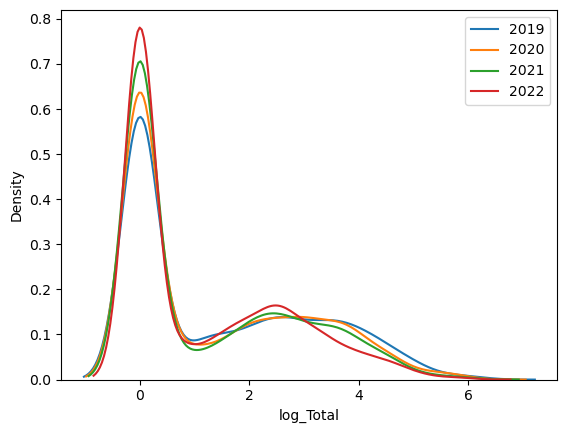

In [43]:
for year in [2019, 2020, 2021,2022]:
    sns.kdeplot(train_df[train_df['Year'] == year]['log_Total'], label=year)
    plt.legend()

In [44]:
yr = train_df[train_df['Year'] == 2022]
mean_absolute_error(yr['Total'], np.zeros(len(yr)))

10.775960539979232

# Regressor

In [45]:
# # reg_resampled_zero_df = zero_df.sample(n=len(nonzero_df) // 2)
# reg_resampled_zero_df = zero_df.copy()
# # extra_zero_df = zero_df.sample(n=2000)
# reg_resampled_data = pd.concat([reg_resampled_zero_df, nonzero_df])

In [46]:
reg_df = full_train_data.copy().reset_index(drop=True)

# reg_zero = reg_df[reg_df['Outbreak'] == 0]
# reg_nonzero = reg_df[reg_df['Outbreak'] == 1]
# reg_zero, _ = train_test_split(reg_zero, train_size=500)

# reg_df = pd.concat([reg_zero, reg_nonzero])
# reg_df = reg_df[reg_df['Outbreak'] == 1]
# reg_df = reg_df.drop(columns=extra_data_cols)
# reg_df['log_prev_year_mean'] = np.log(reg_df['prev_year_mean'] + 1)
# reg_df.drop(columns=['prev_year_mean'], inplace=True)

In [47]:
# reg_df = reg_df[reg_df['Total'] < 50]

In [48]:
# reg_df['Outbreak'] = binary_model.predict(reg_df.drop(columns=['ID', 'Category_Health_Facility_UUID', 'Total', 'Outbreak']))
cat_cols = ['Disease', 'Location', 'loc_dis']
# reg_df = reg_df.sort_values(by='Location')
reg_x = reg_df.drop(columns=['ID', 'Category_Health_Facility_UUID', 'Total', 'log_Total'])
reg_y = reg_df['Total']
# reg_x_train = reg_x[reg_x['Year'] < 2022]
# reg_x_valid = reg_x[reg_x['Year'] == 2022]
# reg_y_train = reg_y[reg_x_train.index]
# reg_y_valid = reg_y[reg_x_valid.index]
reg_x_train, reg_x_valid, reg_y_train, reg_y_valid = train_test_split(reg_x, reg_y, test_size=0.2, stratify=reg_x['Year'], random_state=117)
# reg_x_train, reg_x_valid, reg_y_train, reg_y_valid = train_test_split(reg_x, reg_y, test_size=0.2, random_state=117, shuffle=True)

In [49]:
# reg_train_data = binary_train[binary_train['Total'] != 0].drop(columns=['Outbreak'])
# reg_x_train = reg_train_data.drop(columns=['Total'])
# reg_y_train = reg_train_data['Total']

# reg_valid_data = binary_valid[binary_valid['Total'] != 0].drop(columns=['Outbreak'])
# reg_x_valid = reg_valid_data.drop(columns=['Total'])
# reg_y_valid = reg_valid_data['Total']

In [50]:
reg_params = {
    'iterations': 12000,
    'early_stopping_rounds': 1000,
    'learning_rate': 0.075,
    'loss_function': 'MAE',
    # 'loss_function': 'Logloss',
    # 'eval_metric': 'MAE',a
    'depth': 3,
    'l2_leaf_reg': 4,
    'bagging_temperature': 2,
    'random_strength': 1,
    'border_count': 63,
    # 'od_type': 'IncToDec',
    'verbose': 100,
    # 'subsample': 1.0,
    # 'random_seed': 42,
    'task_type': 'CPU',
}

In [51]:
reg_train_pool = Pool(reg_x_train, reg_y_train, cat_features=cat_cols)
reg_valid_pool = Pool(reg_x_valid, reg_y_valid, cat_features=cat_cols)

In [52]:
reg_model = CatBoostRegressor(**reg_params, cat_features=cat_cols)
reg_model.fit(reg_train_pool, eval_set=reg_valid_pool)

0:	learn: 12.9545582	test: 11.2459948	best: 11.2459948 (0)	total: 61.1ms	remaining: 12m 12s
100:	learn: 7.3472168	test: 6.4759472	best: 6.4750081 (95)	total: 708ms	remaining: 1m 23s
200:	learn: 7.1326264	test: 6.3847077	best: 6.3847077 (200)	total: 1.35s	remaining: 1m 19s
300:	learn: 7.0146974	test: 6.3299553	best: 6.3299553 (300)	total: 1.89s	remaining: 1m 13s
400:	learn: 6.9700255	test: 6.3116192	best: 6.3105462 (378)	total: 2.22s	remaining: 1m 4s
500:	learn: 6.9571009	test: 6.3072195	best: 6.3055876 (467)	total: 2.59s	remaining: 59.4s
600:	learn: 6.9103893	test: 6.3006498	best: 6.2999114 (587)	total: 2.88s	remaining: 54.6s
700:	learn: 6.8904936	test: 6.3002636	best: 6.2988821 (637)	total: 3.16s	remaining: 50.9s
800:	learn: 6.8189720	test: 6.2955131	best: 6.2940151 (796)	total: 3.35s	remaining: 46.9s
900:	learn: 6.7459131	test: 6.2770682	best: 6.2760144 (897)	total: 3.7s	remaining: 45.6s
1000:	learn: 6.6919176	test: 6.2627897	best: 6.2627816 (999)	total: 4.02s	remaining: 44.1s
1100:	

In [53]:
reg_preds = reg_model.predict(reg_x_valid)
reg_preds[reg_preds < 0] = 0
mean_absolute_error(reg_y_valid, reg_preds)

5.967277435540217

KeyError: 'log_Total'

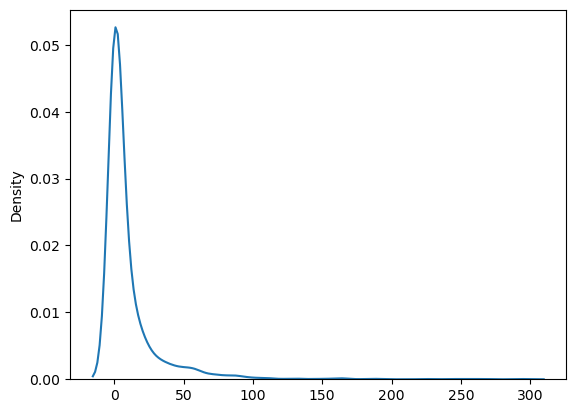

In [54]:
sns.kdeplot(reg_preds, label='Preds')
valid_df = pd.concat([reg_x_valid, reg_y_valid], axis=1)
sns.kdeplot(valid_df['log_Total'], label='Valid Data')
# sns.kdeplot(reg_resampled_data['log_Total'], label='All data')
# sns.kdeplot(train_df[train_df['Year'] == 2022]['log_Total'], label=2022)
plt.legend()

In [ ]:
# sns.kdeplot(np.log(reg_preds + 1), label='Preds')
# valid_df = pd.concat([reg_x_valid, reg_y_valid], axis=1)
# sns.kdeplot(np.log(valid_df['log_Total'] + 1), label='Valid Data')
# # sns.kdeplot(reg_resampled_data['log_Total'], label='All data')
# # sns.kdeplot(train_df[train_df['Year'] == 2022]['log_Total'], label=2022)
# plt.legend()

In [ ]:
valid_total = reg_df.iloc[reg_x_valid.index]['Total']

In [ ]:
mean_absolute_error(valid_total, np.exp(reg_preds) - 1)

In [ ]:
valid_year = reg_x_valid[reg_x_valid['Year'] == 2022]
y_valid_year = reg_y_valid[valid_year.index]
year_reg_preds = reg_model.predict(valid_year)
year_reg_preds[year_reg_preds < 0] = 0
mean_absolute_error(y_valid_year, year_reg_preds)

In [ ]:
sns.kdeplot(year_reg_preds, label='2022 Preds')
sns.kdeplot(valid_df[valid_df['Year'] == 2022]['log_Total'], label='2022 labels')
plt.legend()

In [ ]:
np.exp(reg_preds.max()), np.exp(reg_y_valid.max())
# reg_preds.max(), reg_y_valid.max()

In [ ]:
errors = np.abs(reg_y_valid - reg_preds)

# Combine predictions, true values, and errors into a DataFrame
results = valid_df.copy()
results['Prediction'] = reg_preds
results['Absolute Error'] = errors

# Sort by largest errors
top_losses = results.sort_values(by='Absolute Error', ascending=False)

In [ ]:
importances = reg_model.get_feature_importance()
# feature_names = [f"Feature {i}" for i in range(X.shape[1])]
feature_names = reg_x_train.columns.tolist()

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 20))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance at the top
plt.show()

In [ ]:
# df_22 = train_df[train_df['Year'] == 2022]
# df_22['locdis'] = train_df['Location'] + '_' + train_df['Disease']
# df_23 = test_df.copy()
# df_23['locdis'] = test_df['Location'] + '_' + test_df['Disease']

In [ ]:
# df_22['locdis'].nunique(), df_23['locdis'].nunique()

In [ ]:
# len(np.intersect1d(df_22['locdis'].unique(), df_23['locdis'].unique()))

In [ ]:
# np.setdiff1d(df_23['locdis'].unique(), df_22['locdis'].unique())

# Inference

In [ ]:
final_test_df = full_test_data.copy()
# final_test_df[final_test_df['Disease'] == 'Cholera']['log_prev_year_mean'] = 0

In [ ]:
final_test_df = final_test_df.set_index('ID').reindex(test_df['ID']).reset_index()

In [ ]:
# # final_test_preds = np.zeros(len(final_test_df))
# outbreak_test_preds = binary_model.predict(final_test_df.drop(columns=['ID', 'Category_Health_Facility_UUID', 'Total']))
# final_test_df['Outbreak'] = outbreak_test_preds
# # final_test_preds[outbreak_test_preds == 0] = 0

In [ ]:
# reg_test_df = final_test_df.iloc[outbreak_test_preds == 1]

In [ ]:
reg_test_preds = reg_model.predict(final_test_df.drop(columns=['ID', 'Category_Health_Facility_UUID', 'Total', 'log_Total']))
reg_test_preds

In [ ]:
# processed_test_data = final_test_df.drop(columns=['ID', 'Total', 'log_Total', 'Category_Health_Facility_UUID'])

# reg_test_preds = []

# for model in reg_models:
#     reg_test_preds.append(model.predict(processed_test_data))

# reg_test_preds = np.array(reg_test_preds)

In [ ]:
reg_test_preds[reg_test_preds < 0] = 0
# final_test_preds[outbreak_test_preds == 1] = reg_test_preds

In [ ]:
ensemble_preds = reg_test_preds.mean(axis=0)
# ensemble_preds = np.exp(reg_test_preds) - 1
ensemble_preds

In [ ]:
(ensemble_preds < 0).sum()

In [ ]:
ensemble_preds[ensemble_preds < 0] = 0

In [ ]:
(np.round(ensemble_preds) == 0).sum()
# len(ensemble_preds[ensemble_preds > 1])

In [ ]:
(np.round(ensemble_preds) == 0).sum()/len(test_df)

In [ ]:
submission_df = final_test_df[['ID']].copy()
submission_df['Total'] = np.round(ensemble_preds)
submission_df

In [ ]:
sns.kdeplot(np.log(submission_df['Total'] + 1))

In [224]:
submission_df.to_csv('submission.csv', index=False)